# ECS759P: _Artificial Intelligence_<br>Assignment 2, Question 2

## On convolutional neural networks (CNN)

**Convolution operation**

A convolution operation between two matrices with the same dimensionality is the operation which produces a new matrix of the same dimensionality by multiplying each element $[i, j]$ of one to the element $[i, j]$ of the other.

---

**Convolution for feature extraction**

The key application of convlution is its usage in identifying features from a matrix $M$. It does so by using a filter matrix (i.e. a matrix representing or approximating the feature to be identified) and applying convolution between this filter matrix and each submatrix of $M$ separated by a step $k_1$ (i.e. we go through the submatrices matrix $M$ whose first (top-left-most) cells are separated by $k_1-1$ cells).

At each level of abstraction, we apply $n$ filters to help identify $n$ features in the matrix $M$. To elaborate, we start by identifying $n_1$ filters to help identify $n_1$ features that are more concrete, i.e. less generalised; these are smaller more perceptual features that constitute larger more conceptual features. Then, we stack/combine the results of each feature detection in a clear order, thus obtaining another matrix from which we can extract higher-level features with the same basic method, i.e. filter-based convolution. We repeat this until we have generalised the process for a whole entity (_which is defined by the various features we extracted_).

At the end of this process, we obtain a matrix $M^*$ whose values are the result of filtering out much of noise and irrelevant/non-essential details from the original matrix $M$. This creates much more efficient training data for the neural network (NN). In other words, convolutional neural networks (CNN) map a complex, potentially noisy input matrix to a simpler, potentially less noisy output matrix that is much more feasible for a fully-connected NN to handle.

---

**Pooling after feature extraction**

Furthermore, we can apply pooling, i.e. the process of generalising fixed-sized clusters of $M^*$ separated by a step $k_2$. This generalisation can be done in many ways:

- Getting the maximum of the cluster
- Averaging the values of the cluster
- etc.

Pooling does the following:

- Reduces dimensions & computational complexity
- Reduces parameters to fit over, reducing overfitting
- The above implies that the model is more tolerant toward variation or distortion

---

**Applying resultant data for fully-connected neural network**

Note that the power of a NN is in estimating and generalising an arbitrarily complex, non-linear function that maps a input vector to an output vector. This is vital since many classification problems (ex. image recognition) do not involve linearly separable data points, requiring a non-linear classification. By abstracting the more essential elements from the input matrix, CNN and pooling reduce the complexity of the input both for training and application, enabling a more efficient generalisation and thus a quicker, more accurate estimation of the classification function.

---

**General notes**

- A model can consist of multiple CNN layers
- A model can consist of multiple fully-connected NNs (FCNNs)

---

> REFERENCE: https://www.youtube.com/watch?v=zfiSAzpy9NM

## Key terminology

- **Stride**: The step/dimensions by which each submatrix/cluster of the data is to be separated for filtering or pooling
- **Kernel**: The size of the cluster/filter matrix in the CNN or pooling layer

## Accessing the data

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pandas import DataFrame

train_set = torchvision.datasets.FashionMNIST(root = ".",
                                              train=True,
                                              download=True,
                                              transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".",
                                             train=False,
                                             download=True,
                                             transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=False)
# Fix the seed to be able to get the same randomness across runs
# and hence reproducible outcomes
torch.manual_seed(0)


# If you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

Having a look at the images the data consists of...

Label is: 3
Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


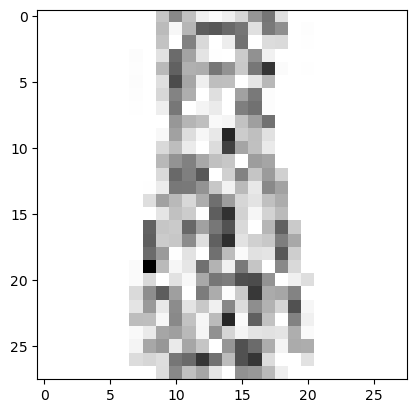

In [ ]:
input_data, label = next(iter(train_loader))
plt.imshow(input_data[0,:,:,:].numpy().reshape(28,28), cmap="gray_r");
print("Label is: {}".format(label[0]))
print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

## Creating the model

In [ ]:
class CNN(nn.Module):
  def __init__(self, activation=nn.ReLU, dropout=0):
    super(CNN, self).__init__()
    # CNN layers:
    self.cnn = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1),
                             activation(),
                             nn.MaxPool2d(kernel_size=2, stride=2),
                             nn.Conv2d(32, 64, kernel_size=5, stride=1),
                             activation(),
                             nn.MaxPool2d(kernel_size=2, stride=2))

    # Fully-connected NN layers:
    self.fcnn = nn.Sequential(nn.Linear(1024, 1024),  # 1st layer
                              activation(),
                              nn.Linear(1024, 256),   # 2nd layer
                              activation(),
                              nn.Dropout(p=dropout),
                              nn.Linear(256, 10))     # Output layer

    # The processor architecture to use:
    self.device = torch.device("cuda:0")
  #================================================

  # Forward method:
  def forward(self, x):
    x = self.cnn(x)
    x = x.view(x.size(0), -1)
    x = self.fcnn(x)
    return x

  #================================================

  # Helper function to initialise weights of each layer:
  def __init_weights(self, model):
    # Initialise linear or convolutional layer:
    if isinstance(model, nn.Linear) or isinstance(model, nn.Conv2d):
        torch.nn.init.xavier_normal_(model.weight)

  #================================================

  # Function to evaluate the accuracy of the predictions:
  # NOTE: Accuracy = Correct predictions / Total predictions
  '''
  REFERENCE FOR CODE:
  Following code taken from `Lab7_CNN_Classification_task_solutions.ipynb`
  '''
  def evaluate(self, dataloader):
    total, correct = 0,0
    # Turn on evaluate mode, this de-activates certain modes such as dropout:
    # NOTE: This is good practice to include in your projects
    self.eval()
    for data in dataloader:

      inputs, labels = data
      inputs, labels = inputs.to(self.device), labels.to(self.device)
      net = self.to(self.device)
      outputs = net(inputs)
      '''
      NOTE ON THE ABOVE:
      We take the index of the class that received the highest value. We take
      `outputs.data` so that no backpropagation is performed for these outputs.
      '''
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      # .item() takes Python float values from the tensor
      correct += (pred == labels).sum().item()
    return 100*correct/total # Returning as percentage

  #================================================

  # Training loop:
  def trainingLoop(self, trainLoader, testLoader, nEpochs=30, lr=0.1):
    # Optimiser (i.e. method of updating & optimising weights):
    # NOTE: We shall be using stochastic gradient descent
    net = self.to(self.device)
    # Initialise weights:
    net.apply(self.__init_weights)
    optimiser = torch.optim.SGD(self.parameters(), lr=lr)
    #------------------------------------
    # Loss function:
    # NOTE: We shall be using cross-entropy loss
    loss = nn.CrossEntropyLoss()
    loss.to(self.device)
    #------------------------------------
    # Training loop:
    epochLossList, trainAccuracy, testAccuracy = [], [], []
    i_prev = 0
    # The main loop:
    print('[', end='')
    for i in range(nEpochs):
      epochLoss = 0
      # Progress bar (maximum length=30):
      if int(i/(nEpochs/30)) > int(i_prev/(nEpochs/30)): print('.', end='')
      i_prev = i
      for j, data in enumerate(trainLoader):
        # Initialisation:
        self.train() # Setting the model to training mode
        inputs, labels = data
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        optimiser.zero_grad() # Resetting calculated gradients to zero

        # Predictions:
        outputs = self.forward(inputs)

        # Backpropagation:
        L = loss(outputs, labels)
        L.backward()
        optimiser.step()
        epochLoss += L.item()

      epochLossList.append(epochLoss)
      trainAccuracy.append(self.evaluate(trainLoader))
      testAccuracy.append(self.evaluate(testLoader))
    print(']')
    return {"epochLossList":epochLossList,
            "trainAccuracy":trainAccuracy,
            "testAccuracy":testAccuracy}

**PROGRAMMING NOTE 1**: **Format for** `kernel_size`, `stride`, **etc.**<br>The parameters `kernel_size`, `stride`, `padding` and `dilation` can either be:

- A single integer (_here, the same value is used for the height and width dimension_)
- A tuple of two integers (_here, the 1st integer is used for the height dimension, and the 2nd integer for the width dimension_)

---

**PROGRAMMING NOTE 2**: `torch.Tensor.view`:<br>
Returns a new tensor with the same data as the calling tensor object but of a different shape.

> REFERENCE: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

---

**CONCEPTUAL NOTE**: **Loss function used**:<br>
The task we want the convolutional neural network (CNN) to perform is multi-class classification, i.e. we want the CNN to sort any observations, i.e. the image, into one of many labels (classes), which in this case correspond to the type of clothing depicted by the image. In practice, we do such multi-class classification by obtaining a probability value for each class that indicates the probability that the given observation belongs to the given class. In other words, we estimate the probability distributions for each class, wherein the probability densities correspond to the likelihood of a given observation (translated into a tuple of values of a set of features) belonging to the given class. For obtaining the loss function in such a problem, the loss function must:

- Deal with the accuracy of the estimation of probability distributions
- Give substantial gradients despite the small range of the predictions (which range from 0 to 1)
- Consider only the predictions for the observed classes

**NOTE**: _Loss function is relevant only in training, so note that the following is discussed in the context of training the CNN._

The **cross-entropy loss** function is one that satisfies the above conditions, and thus, is used widely in multi-class classification problems. Its formula per observation, i.e. per prediction, is as follows:

$
H(X) = -\sum_{x \in X} P(X=x) \log(f(X=x))
$

Here, we have:

- $X$: The random variable denoting the label (class)
- $x$: A possible label (class)
- $P(X=x)$: The observed probability of the label being $x$
- $f(X=x)$: The estimated probability of the label being $x$
- $H(X)$: The entropy calculated for $X$

**NOTE**: _The logarithm used is generally in base_ $2$, _since entropy is associated with the number of bits required to encode an event or its likelihood; the higher the entropy, the higher the bits that are required. However, we can also use other bases, such as_ $e$.

$-\log(f(X=x))$ and hence $H(x)$ is inversely proportional to $f(X=x)$, i.e. the higher the estimated probability of $X=x$, the lower the loss value for the particular class $x$. In our case, since we know which class the given observation belongs to, $P(X=x)$ is simply $1$ for a particular $x$ and $0$ for every other $x$. Hence, in our case and for neural networks in general, the above formula reduces to:

$
H(X=x) = -log(f(X=x))
$

Here, $H(X=x)$ is the cross entropy value for the given class $x$, which is known in training. This is essentially

> ADDITIONAL REFERENCES:
> - https://www.youtube.com/watch?v=6ArSys5qHAU
> - https://analyticsindiamag.com/a-beginners-guide-to-cross-entropy-in-machine-learning/
> - https://365datascience.com/tutorials/machine-learning-tutorials/cross-entropy-loss/

---

**IMPLEMENTATION NOTE**:<br>
In the CNN implemented, we have not given the final output as an array of probabilities, but this is not necessary for the application of the loss function `nn.CrossEntropyLoss`, which performs the softmax operation needed to obtain the final output as an array of probabilities.

In [ ]:
M1 = CNN()
R1 = M1.trainingLoop(train_loader, test_loader, nEpochs=30)

[.............................]


In [ ]:
print("Final train cost:", R1["epochLossList"][-1])
print("Final train accuracy:", R1["trainAccuracy"][-1])
print("Final test accuracy:", R1["testAccuracy"][-1])

Final train cost: 47.60817497196069
Final train accuracy: 99.58333333333333
Final test accuracy: 91.0


### Plotting the loss & accuracy over epochs

Small helper function to make the plot presentable...

In [ ]:
def _(title, xlabel, ylabel, legend=False):
    plt.title(title)
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    if legend: plt.legend()
    plt.show()

Plotting the accuracy of classification over epochs...

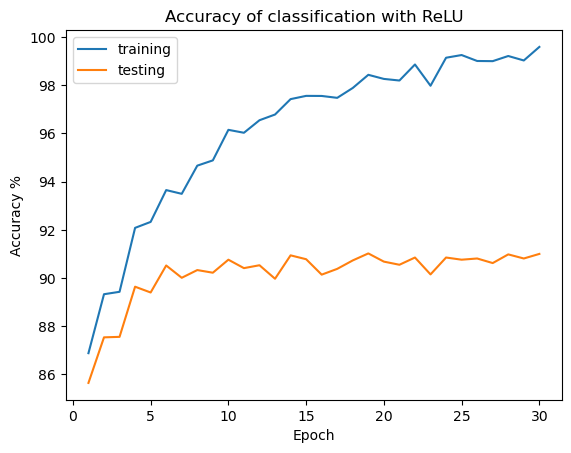

In [ ]:
plt.plot(range(1, len(R1["trainAccuracy"])+1), R1["trainAccuracy"], label="training")
plt.plot(range(1, len(R1["testAccuracy"])+1), R1["testAccuracy"], label="testing")
_("Accuracy of classification with ReLU", "Epoch", "Accuracy %", legend=True)

**COMMENTS**:

Note that the performance, i.e. accuracy over epochs has random spikes at certain points, but we shall ignore these and focus on the overall trend. We observe that for the speed of performance change (i.e. rate of change in accuracy) rises rapidly for the initial few epochs; the rate of this change reduces for the later epochs. More specifically, we observe that the training accuracy keeps rising (overall) until epoch 30, but its rate of increase decreases gradually. On the other hand, the testing accuracy rises rapidly only until around epoch 6 or 7, after which it stays roughly constant until epoch 30.

Plotting the loss values per epoch...

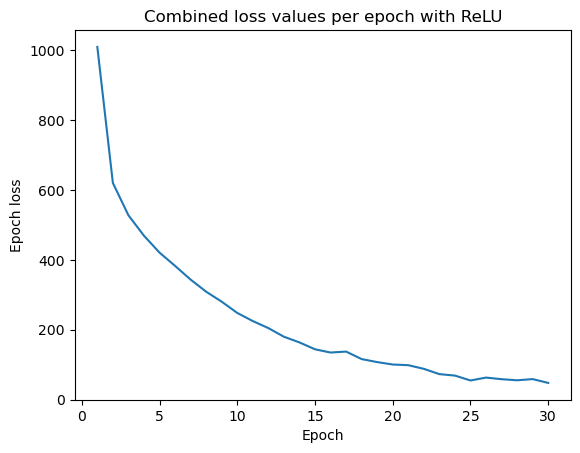

In [ ]:
plt.plot(range(1, len(R1["epochLossList"])+1), R1["epochLossList"])
_("Combined loss values per epoch with ReLU", "Epoch", "Epoch loss")

**COMMENTS**:

The above curve of loss values is for training loss only. We observe that for the of loss values per epoch falls rapidly for the initial few epochs; the rate of this change reduces for the later epochs. This coincides with the way the previously discussed training accuracy changes over epochs.

### Comparing with ELU activation function

In [ ]:
M2 = CNN(activation=nn.ELU)
R2 = M2.trainingLoop(train_loader, test_loader, nEpochs=30)

[.............................]


In [ ]:
DataFrame(data={"Activation":["ELU", "ReLU"],
                "Final train accuracy":[R1["trainAccuracy"][-1], R2["trainAccuracy"][-1]],
                "Final test accuracy":[R1["testAccuracy"][-1], R2["testAccuracy"][-1]]},
          index=["Model M1", "Model M2"])

,Activation,Final train accuracy,Final test accuracy
Model M1,ELU,99.583333,91.00
Model M2,ReLU,99.426667,90.69


Some extra visualisation...

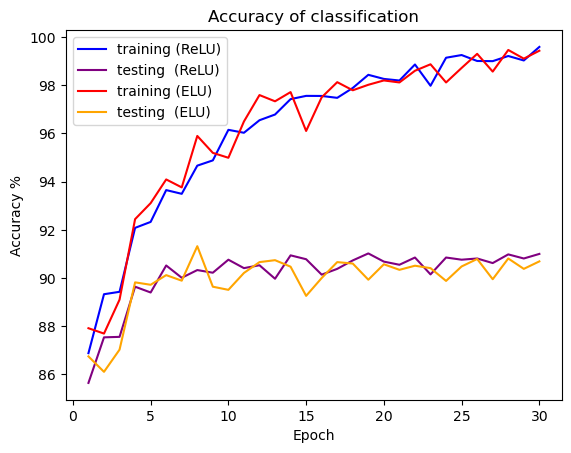

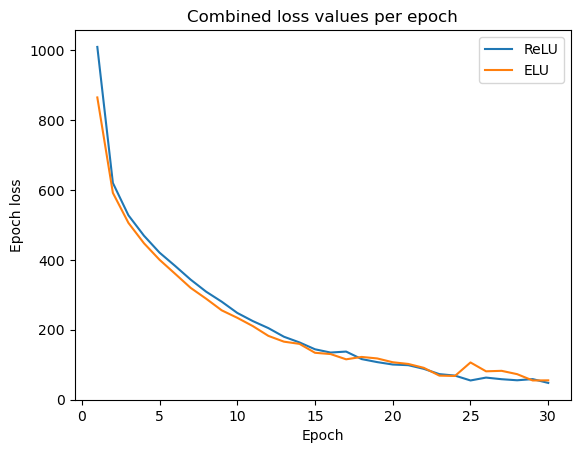

In [ ]:
plt.plot(range(1, len(R1["trainAccuracy"])+1), R1["trainAccuracy"], label="training (ReLU)", color="blue")
plt.plot(range(1, len(R1["testAccuracy"])+1), R1["testAccuracy"], label="testing  (ReLU)", color="purple")
plt.plot(range(1, len(R2["trainAccuracy"])+1), R2["trainAccuracy"], label="training (ELU)", color="red")
plt.plot(range(1, len(R2["testAccuracy"])+1), R2["testAccuracy"], label="testing  (ELU)", color="orange")
_("Accuracy of classification", "Epoch", "Accuracy %", legend=True)

plt.plot(range(1, len(R1["epochLossList"])+1), R1["epochLossList"], label="ReLU")
plt.plot(range(1, len(R2["epochLossList"])+1), R2["epochLossList"], label="ELU")
_("Combined loss values per epoch", "Epoch", "Epoch loss", legend=True)

**COMMENTS**:

Comparing the activation functions ""ReLU" (rectified linear unit) and "ELU" (exponential linear unit), we observe only a negligible difference in both the final training and testing accuracies, indicating that these activation functions are similar in performance for multi-class classification. To understand the similarity on their performance, we shall look into their formulations and properties:

ReLU:

$
f(x > 0) = x, f(x \leq 0) = 0
$

ELU:

$
f(x > 0) = x, f(x \leq 0) = \alpha e^x-1
$

Here, $\alpha$ is a constant. Also note that $x$ in both the above cases denotes the input to the neuron, which is in fact the weighted sum of some subset of outputs from the previous layer. We can see that ReLU and ELU are very similar, with the key difference being that ELU produces negative outputs for negative inputs which having a positive gradient that increases the closer the negative input is to $0$. This allows weights to adjust even when they lead to negative weighted sums. This offers a strong alternative to ReLU, since one of ReLU's key limitations is the case where large weight updates make inputs to certain neurons (hence, the associated activation function) always negative, regardless of the initial input to the network. In such a case, these neurons  will stop responding to variations in error or input because the gradient\* for this neuron becomes zero; this is called the dying ReLU problem.

\*_The gradient of the activation function becomes zero; this gradient is a multiplier in the partial derivative of the loss function (with respect to the neuron's weight vector) used in gradient descent, which is where weights get updated._

In our case, the similar performance of ReLU and ELU suggests that the issue of dying ReLU does not arise, at least for the learning rate used ($0.1$).

> REFERENCES:
> - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html
> - https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

### Comparing different learning rates

In [ ]:
"""
from copy import deepcopy
# Reducing the size of the training data set:
nTrain = len(train_loader.dataset)
trainLoader = deepcopy(train_loader)
trainLoader.dataset.data = train_loader.dataset.data[:int(nTrain/2)]
"""

R = [] # For storing the results of each
lrList = [0.001, 0.1, 0.5, 1.0, 10.0]
for lr in lrList:
    M = CNN(activation=nn.ReLU)
    R.append(M.trainingLoop(train_loader, test_loader, nEpochs=30, lr=lr))

[.............................]
[.............................]
[.............................]
[.............................]
[.............................]


Printing the data...

In [ ]:
DataFrame(data={"Learning rate":lrList,
                "Final cost":[r["epochLossList"][-1] for r in R],
                "Final train accuracy":[r["trainAccuracy"][-1] for r in R],
                "Final test accuracy":[r["testAccuracy"][-1] for r in R]})

,Learning rate,Final cost,Final train accuracy,Final test accuracy
0,0.001,673.850306,87.176667,85.88
1,0.100,49.237395,98.810000,90.68
2,0.500,4324.262487,10.000000,10.00
3,1.000,4331.506782,10.000000,10.00
4,10.000,NaN,10.000000,10.00


Observing speed and stability of convergence in accuracy...

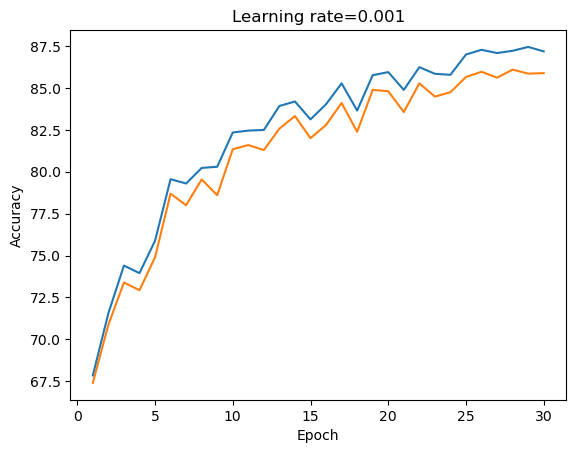

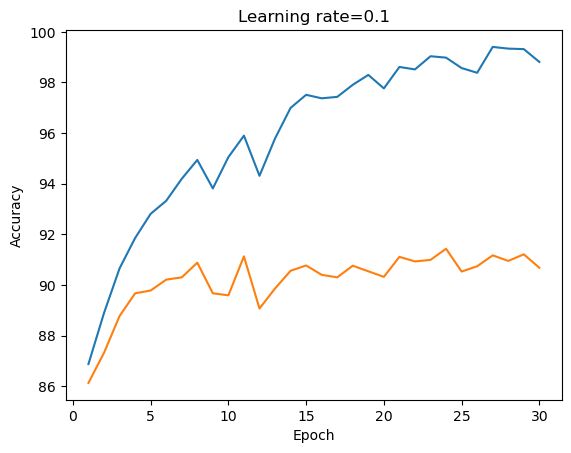

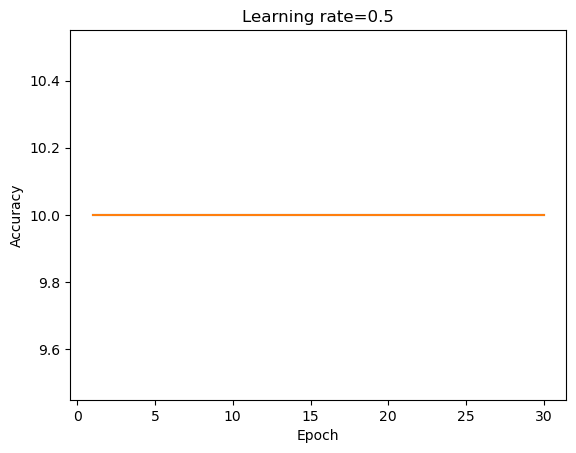

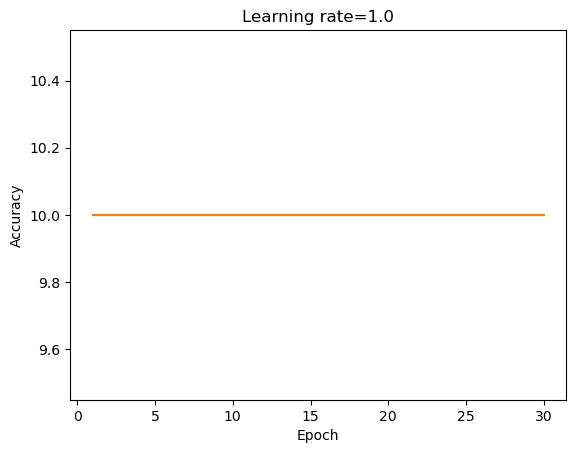

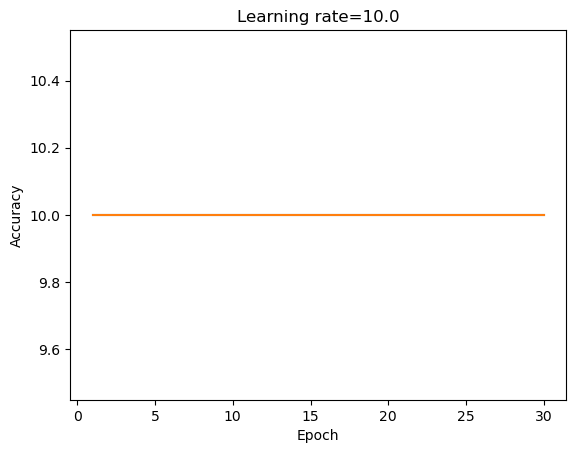

In [ ]:
for lr, r in list(zip(lrList, R)):
    plt.plot(range(1, len(r["trainAccuracy"])+1), r["trainAccuracy"])
    plt.plot(range(1, len(r["testAccuracy"])+1), r["testAccuracy"])
    _(f"Learning rate={lr}", "Epoch", "Accuracy")

Observing speed and stability of convergence in loss...

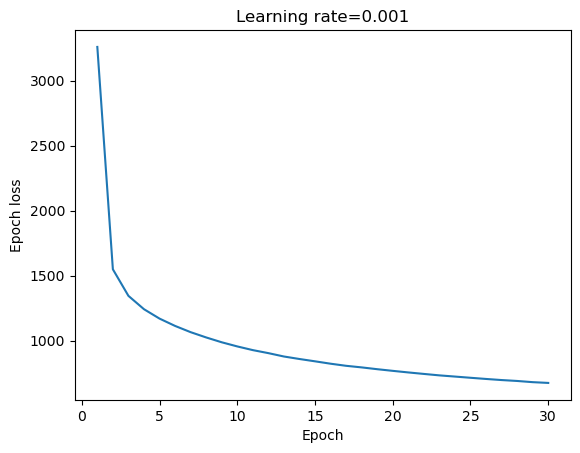

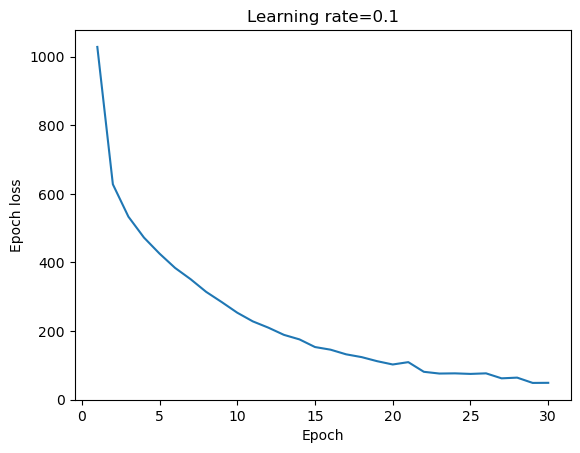

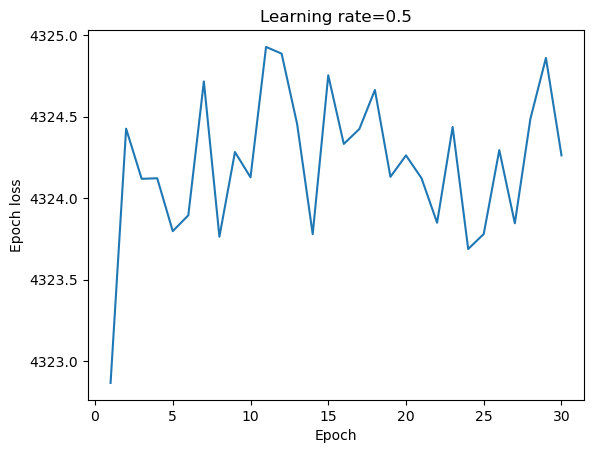

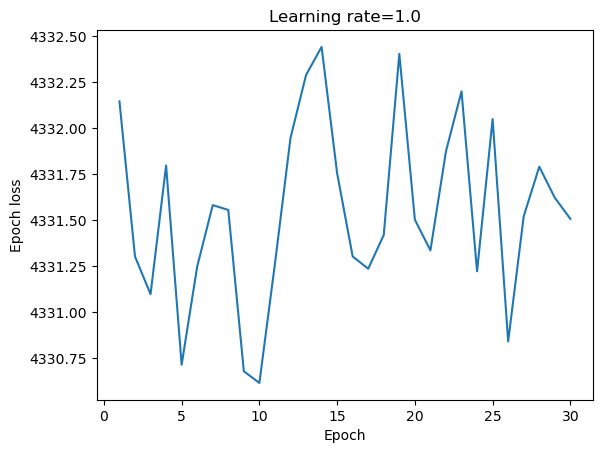

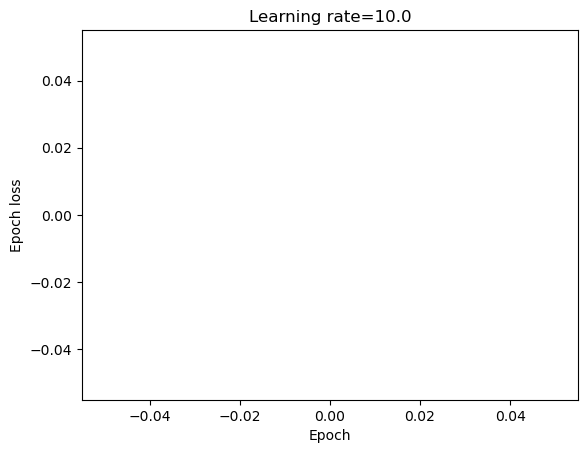

In [ ]:
# Comparing the speed of convergence:

for lr, r in list(zip(lrList, R)):
    plt.plot(range(1, len(r["epochLossList"])+1), r["epochLossList"])
    _(f"Learning rate={lr}", "Epoch", "Epoch loss")

**COMMENTS**:

We observe the following with respect to training and testing accuracy:

- Highest for learning rate $0.1$ (above $95\%$ for training & above $90\%$ for testing)
- High for learning rate $0.001$ (around $85\%$ for both training & testing)
- Very low ($10\%$) for all attempted learning rates above $0.1$

We observe the following with respect to the final per-epoch loss:

- Lowest for learning rate $0.1$
- Significantly higher (by one order of magnitude) for learning rate $0.001$
- Much higher (by two orders of magnitude) for learning rates $0.5$ & $1.0$
- `NaN` for learning rate $10.0$

The above indicates that the training cost (per-epoch loss value) converges for both learning rates $0.01$ and $0.1$, but converges significantly faster for learning rate $0.1$. The `NaN` (not-a-number) value for learning rate $10.0$ can be interpreted as a cost so high that it exceeds our computational limits. This is due to the massive divergence or explosion in the per-epoch loss values, caused by the large learning rate used.

From the graphs for the per-epoch loss values for each learning rate, we observe the following:

- Learning rates $0.001$ & $0.1$ have a stable convergence (loss consistently decreases at an inverse-exponential rate, converging asymptotically)
- Learning rates $0.5$ & $1.0$ have unstable changes in the loss values, leading to highly inconsistent change in performance with no improvement overall
- Learning rate $10.0$ has an empty plot, indicating that its loss values exploded beyond computational limits from the first epoch

**Trade-off between speed and stability**...

Hence, only $0.001$ & $0.1$ show a stable convergence in loss values, translating to a stable improvement in performance over multiple epochs. However, from the plots of the per-epoch loss values, we observe that the graph for learning rate $0.001$ is smoother, i.e. less prone to random fluctuations than the learning rate $0.1$, indicating that the convergence with a lower learning rate leads to greater stability in performance change. This highlights the speed vs. stability trade-off; up to a point, higher learning rates may show faster convergence of cost (loss values) overall but with greater amounts of random fluctuations in the cost, whereas lower learning rates show slower convergence but a more stable rate of change over epochs.

Comparing the plots of the training and testing accuracy for the learning rates $0.001$ and $0.1$ further reinforces this point. The graph for learning rate $0.001$ shows a more steady increase in both training and testing accuracy, even though the overall convergence is lower than it is for learning rate $0.1$. On the other hand, learning rate $0.1$ shows a greater overall increase in both training and testing accuracy, with a high rate of change initially, but the graph shows larger fluctuations in accuracy for both training and testing (_though accuracy keeps increasing overall for training, whereas testing accuracy remains constant overall after a point_).

**Additional comments**...

Interestingly, the training and testing accuracy for learning rate $0.001$ are much closer together than for learning rate $0.1$; the latter shows a greater divergence between training and testing accuracy over multiple epochs. This could be because of the slower convergence with learning rate $0.01$, which prevents the accuracy from rising enough to reach the point of divergence; this is relevant here because we observe that even for learning rate $0.1$, training and testing accuracy are relatively close together until a certain level of accuracy is reached, a level that is not yet reached with learning rate $0.001$ in the same number of epochs.

### Testing dropout

In [ ]:
myCNN = CNN(activation=nn.ReLU, dropout=0.3)
R3 = myCNN.trainingLoop(train_loader, test_loader, nEpochs=30, lr=0.1)

[.............................]


In [ ]:
DataFrame(data={"Dropout":[0, 0.3],
                "Final cost":[R1["epochLossList"][-1], R3["epochLossList"][-1]],
                "Final train accuracy":[R1["trainAccuracy"][-1], R3["trainAccuracy"][-1]],
                "Final test accuracy":[R1["testAccuracy"][-1], R3["testAccuracy"][-1]]},
          index=["Model M1", "Model M3"])

,Dropout,Final cost,Final train accuracy,Final test accuracy
Model M1,0.0,47.608175,99.583333,91.00
Model M3,0.3,70.234269,99.196667,90.91


Some extra visualisation...

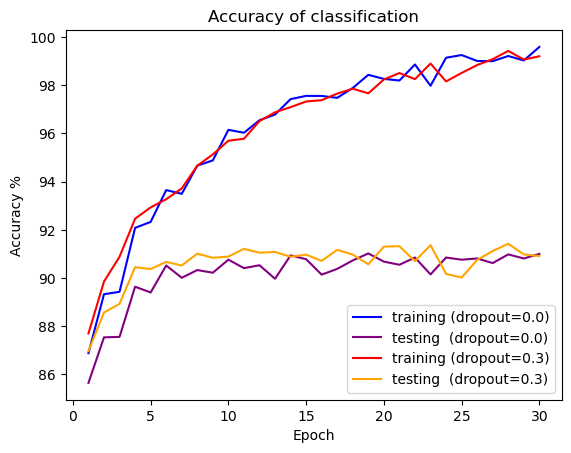

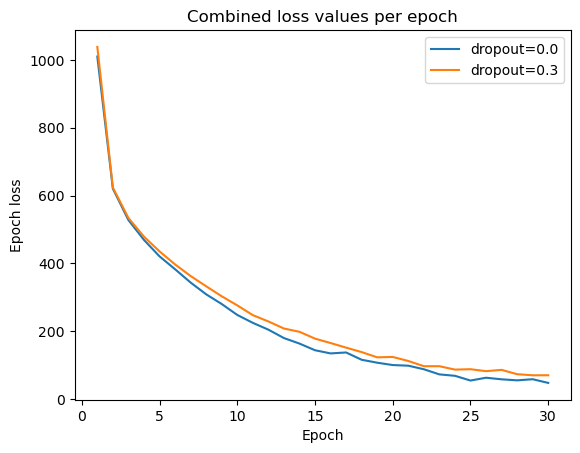

In [ ]:
plt.plot(range(1, len(R1["trainAccuracy"])+1), R1["trainAccuracy"], label="training (dropout=0.0)", color="blue")
plt.plot(range(1, len(R1["testAccuracy"])+1), R1["testAccuracy"], label="testing  (dropout=0.0)", color="purple")
plt.plot(range(1, len(R3["trainAccuracy"])+1), R3["trainAccuracy"], label="training (dropout=0.3)", color="red")
plt.plot(range(1, len(R3["testAccuracy"])+1), R3["testAccuracy"], label="testing  (dropout=0.3)", color="orange")
_("Accuracy of classification", "Epoch", "Accuracy %", legend=True)

plt.plot(range(1, len(R1["epochLossList"])+1), R1["epochLossList"], label="dropout=0.0")
plt.plot(range(1, len(R3["epochLossList"])+1), R3["epochLossList"], label="dropout=0.3")
_("Combined loss values per epoch", "Epoch", "Epoch loss", legend=True)

**COMMENTS**:

The training and testing accuracy show negligible difference when comparing the model that uses dropout with rate $0.3$ to the model that does not use dropout (i.e. that uses dropout with rate $0.0$), indicating that the performance was not greatly affected (positively or negatively) by using dropout with rate $0.3$. The graphs of the accuracy and per-epoch loss value does not indicate a significant difference in performance either. The difference in the final costs do not indicate a clear difference in performance, especially since the difference is proportionally quite small (proportional to the maximum and average cost).

**The relevance of dropout**...

Dropout is a computationally cheap method of avoiding overfitting. Dropout forcibly deactivates certain neurons from the selected hidden layer, which reduces the rate at which the neurons may fine-tune their weights to the noise present in the training data. Additionally, dropout encourages the neural network to learn more sparse solutions to the classification problem (i.e. solutions that involve a less dense collection of neurons), potentially improving computational efficiency.

> REFERENCE: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

**In our case**...

In our case, we observe that overfitting is not reduced, i.e. training accuracy still significantly exceeds and increases at a greater rate than testing accuracy, indicating that using dropout with rate $0.3$ has no clear effect on overfitting.